In [ ]:
!pip install transformers pandas scikit-learn torch tqdm huggingface_hub matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
!huggingface-cli cache purge

usage: huggingface-cli <command> [<args>]
huggingface-cli: error: argument {download,upload,repo-files,env,login,whoami,logout,auth,repo,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag,version,upload-large-folder}: invalid choice: 'cache' (choose from 'download', 'upload', 'repo-files', 'env', 'login', 'whoami', 'logout', 'auth', 'repo', 'lfs-enable-largefiles', 'lfs-multipart-upload', 'scan-cache', 'delete-cache', 'tag', 'version', 'upload-large-folder')


In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

import torch
from torch import nn
from transformers import BertModel, BertTokenizer
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import HfApi, Repository, login
import json

In [ ]:
login()

In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import re

# Load and preprocess dataset
df = pd.read_excel("dataset.xlsx")  # Replace with the path to your dataset

# Buat fitur 'tweet_per_day'
df["created_at"] = pd.to_datetime(df["created_at"])
if df["created_at"].dt.tz is None:
    df["created_at"] = df["created_at"].dt.tz_localize("UTC")
df["created_at"] = df["created_at"].dt.tz_convert(None)

df["min_date"] = df.groupby("user_id_str")["created_at"].transform("min")
df["max_date"] = df.groupby("user_id_str")["created_at"].transform("max")
df["days_active"] = (df["max_date"] - df["min_date"]).dt.days + 1
df["tweet_count"] = df.groupby("user_id_str")["user_id_str"].transform("count")
df["tweet_per_day"] = df["tweet_count"] / df["days_active"]
df.drop(["min_date", "max_date", "days_active", "tweet_count"], axis=1, inplace=True)


# Columns used in the model
text_col = "full_text"
label_col = "label"
numerical_cols = ["favorite_count", "retweet_count", "reply_count", "quote_count", "tweet_per_day"]

# Drop rows with missing values in important columns
df.dropna(subset=[text_col, label_col] + numerical_cols, inplace=True)

# Cleansing function for text data
def clean_text(text):
    text = str(text)
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|pic\.twitter\.com\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply cleansing to the text column
df[text_col] = df[text_col].apply(clean_text)

# Optional: Ensure numeric columns are of the correct type and fill NaNs if needed
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric (if not already)
    df[col].fillna(0, inplace=True)  # Fill missing with 0 if any remain

# Optional: Print sample data to verify
print(df[[text_col] + numerical_cols + [label_col]].head())


<ipython-input-6-30008ed88942>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"])


                                           full_text  favorite_count  \
0  beda jenis bang kalo kucing hutan gedenya gak ...               1   
1            siap direkrut masuk sirkel elite mas ge               2   
2                          alhamdulillah masih dapet               0   
3  pasti adalah carinya di resto khusus indo bias...               0   
4             gasss pindah negara dong ketuaa wkwkwk               3   

   retweet_count  reply_count  quote_count  tweet_per_day label  
0              0            0            0       8.350877   bot  
1              0            0            0       8.350877   bot  
2              0            0            0       8.350877   bot  
3              0            0            0       8.350877   bot  
4              0            1            0       8.350877   bot  


<ipython-input-6-30008ed88942>:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)  # Fill missing with 0 if any remain


In [ ]:
# Map labels to numbers
label_map = {'human': 0, 'bot': 1}
df[label_col] = df[label_col].map(label_map)

# Extract text and labels
X_text = df[text_col].astype(str).tolist()
y = df[label_col].astype(int).values

# Normalize numerical features
# Normalize numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df[numerical_cols])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
encoded = tokenizer(
    X_text,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class BotDetectionDataset(Dataset):
    def __init__(self, input_ids, attention_mask, numerical_features, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.numerical_features = torch.tensor(numerical_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'numerical_features': self.numerical_features[idx],
            'labels': self.labels[idx]
        }

# Split data into training and test sets
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

train_dataset = BotDetectionDataset(
    input_ids=encoded['input_ids'][train_idx],
    attention_mask=encoded['attention_mask'][train_idx],
    numerical_features=X_numerical[train_idx],
    labels=y[train_idx]
)

test_dataset = BotDetectionDataset(
    input_ids=encoded['input_ids'][test_idx],
    attention_mask=encoded['attention_mask'][test_idx],
    numerical_features=X_numerical[test_idx],
    labels=y[test_idx]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
# Define model
class IndoBERTBotClassifier(nn.Module):
    def __init__(self, num_numerical_features=5, hidden_dim=128):
        super().__init__()
        self.bert = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(768 + num_numerical_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, numerical_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_output.last_hidden_state[:, 0, :]  # [CLS] token
        combined = torch.cat((cls_output, numerical_features), dim=1)
        return self.classifier(combined).squeeze()


In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IndoBERTBotClassifier(num_numerical_features=len(numerical_cols)).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
def train(model, dataloader):
    model.train()
    total_loss = 0
    all_labels = []
    all_preds = []

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        num_feat = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, num_feat)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (outputs > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Menghitung metrik
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    accuracy = (np.array(all_labels) == np.array(all_preds)).mean()

    return total_loss / len(dataloader), accuracy, precision, recall, f1

# Train model and track metrics
epoch_metrics = []

for epoch in range(10):
    loss, accuracy, precision, recall, f1 = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    epoch_metrics.append({
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })



pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Training:   1%|          | 11/1000 [00:01<01:22, 11.94it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Training: 100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


Epoch 1, Loss: 0.3683, Accuracy: 0.8311, Precision: 0.8511, Recall: 0.8046, F1: 0.8272


Training: 100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


Epoch 2, Loss: 0.2532, Accuracy: 0.8940, Precision: 0.9138, Recall: 0.8712, F1: 0.8920


Training: 100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


Epoch 3, Loss: 0.1469, Accuracy: 0.9431, Precision: 0.9513, Recall: 0.9347, F1: 0.9429


Training: 100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


Epoch 4, Loss: 0.0816, Accuracy: 0.9687, Precision: 0.9709, Recall: 0.9667, F1: 0.9688


Training: 100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


Epoch 5, Loss: 0.0534, Accuracy: 0.9800, Precision: 0.9821, Recall: 0.9780, F1: 0.9801


Training: 100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


Epoch 6, Loss: 0.0462, Accuracy: 0.9830, Precision: 0.9846, Recall: 0.9815, F1: 0.9831


Training: 100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


Epoch 7, Loss: 0.0345, Accuracy: 0.9868, Precision: 0.9869, Recall: 0.9868, F1: 0.9869


Training: 100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


Epoch 8, Loss: 0.0357, Accuracy: 0.9870, Precision: 0.9878, Recall: 0.9863, F1: 0.9871


Training: 100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


Epoch 9, Loss: 0.0303, Accuracy: 0.9891, Precision: 0.9902, Recall: 0.9881, F1: 0.9891


Training: 100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]

Epoch 10, Loss: 0.0245, Accuracy: 0.9911, Precision: 0.9915, Recall: 0.9908, F1: 0.9912


In [ ]:
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        num_feat = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask, num_feat)
        probs = torch.sigmoid(outputs)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend((outputs > 0.5).long().cpu().numpy())
        y_probs.extend(probs.cpu().numpy())


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            num_feat = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, num_feat)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).long().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return total_loss / len(dataloader), accuracy, precision, recall, f1


In [ ]:
val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, test_loader)
print(f"[Validation] Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")


Evaluating: 100%|██████████| 250/250 [00:04<00:00, 54.79it/s]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      2008
         1.0       0.85      0.88      0.86      1992

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000

[Validation] Loss: 0.7252, Acc: 0.8600, Precision: 0.8459, Recall: 0.8790, F1: 0.8621


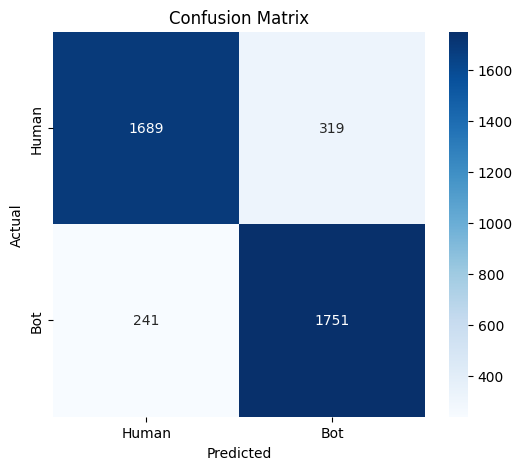

In [ ]:
# Metrics: confusion matrix, classification report, and ROC AUC
conf_matrix = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("./bot-detection-indobert/confusion_matrix.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()

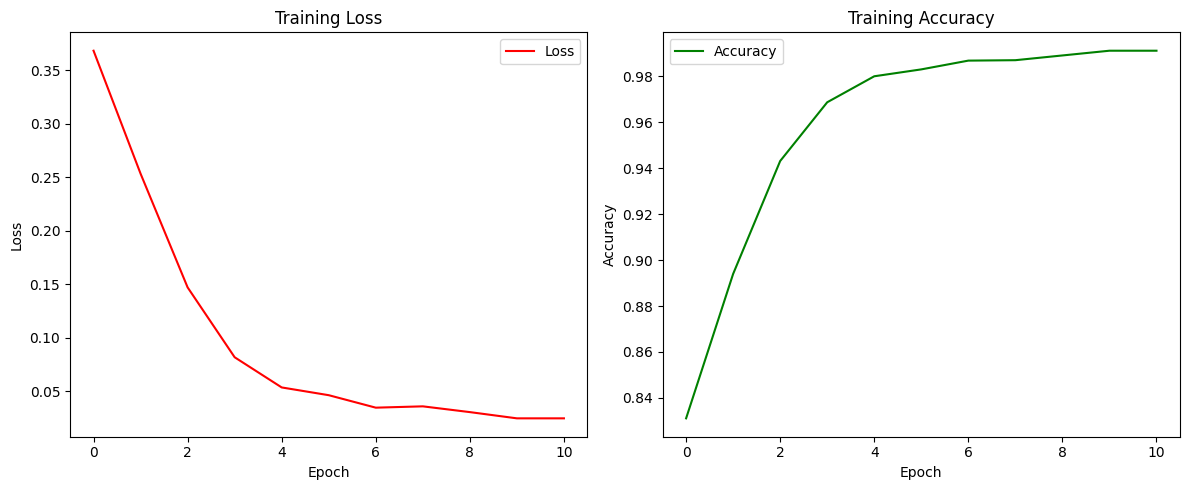

In [ ]:
import matplotlib.pyplot as plt

# Kalau belum ada, ambil dari epoch_metrics
losses = [m["loss"] for m in epoch_metrics]
accuracies = [m["accuracy"] for m in epoch_metrics]

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("./bot-detection-indobert/training_phase.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()

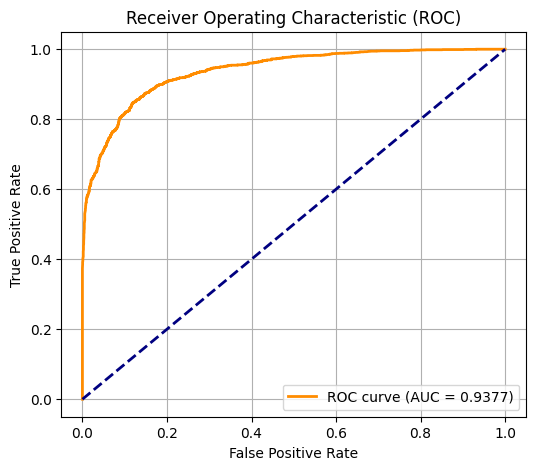

In [ ]:
# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("./bot-detection-indobert/roc.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score

def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            num_feat = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, num_feat)
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_probs


In [ ]:
epoch_metrics.append({
    "loss": loss,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})


In [ ]:
def evaluate_return_preds(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            num_feat = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, num_feat)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).long().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

# Pastikan baris di bawah ini dijalankan setelah definisi fungsi di atas

val_loss, val_acc, val_prec, val_rec, val_f1, true_labels, pred_labels = evaluate_return_preds(model, test_loader)

report = classification_report(true_labels, pred_labels, zero_division=0)


Evaluating: 100%|██████████| 250/250 [00:04<00:00, 55.08it/s]


In [ ]:
from sklearn.metrics import classification_report

# Misal true_labels dan pred_labels sudah tersedia dari evaluasi akhir
report = classification_report(true_labels, pred_labels, zero_division=0)

readme_file = "README.md"

with open(readme_file, "w") as f:
    f.write("# IndoBERT for Bot Detection on Platform X\n\n")
    f.write("This model uses **IndoBERT** to classify Twitter/X accounts as bots or humans based on their textual content and numeric features.\n\n")

    f.write("## Model Architecture\n")
    f.write("- Base Model: `indobenchmark/indobert-base-p1`\n")

    f.write("## Dataset\n")
    f.write("The dataset includes Indonesian tweets with labels (`0` for human, `1` for bot), along with additional numeric features such as `favorite_count`, `retweet_count`, `reply_count`, and `quote_count`.\n\n")

    f.write("## Training Details\n")
    f.write(f"- Loss Function: Binary Cross Entropy (BCELoss)\n")
    f.write(f"- Optimizer: AdamW (lr = 2e-5)\n")
    f.write(f"- Epochs: {len(epoch_metrics)}\n")
    f.write(f"- Max Token Length: 128\n")  # sesuaikan jika berbeda
    f.write(f"- Batch Size: 16\n\n")       # sesuaikan jika berbeda

    f.write(f"- Epochs: {len(epoch_metrics)}\n")

    f.write("| Epoch | Train Loss | Val Accuracy | Precision | Recall | F1-score |\n")
    f.write("|-------|------------|--------------|-----------|--------|----------|\n")
    for i, m in enumerate(epoch_metrics):
        f.write(f"| {i+1} | {m['loss']:.4f} | {m['accuracy']:.4f} | {m['precision']:.4f} | {m['recall']:.4f} | {m['f1']:.4f} |\n")

    f.write("## Evaluation Results\n")
    f.write(f"**Final Validation Accuracy**: {val_acc:.4f}\n\n")
    f.write(f"**Final Precision**: {val_prec:.4f}\n")
    f.write(f"**Final Recall**: {val_rec:.4f}\n")
    f.write(f"**Final F1-score**: {val_f1:.4f}\n\n")
    f.write("### Confusion Matrix\n")
    f.write("![Confusion Matrix](./confusion_matrix.png)\n\n")
    f.write("### Training Phase\n")
    f.write("![Training Phase](./training_phase.png)\n\n")

    f.write("### Classification Report\n")
    f.write("```\n")
    f.write(report)
    f.write("\n```\n")

In [ ]:
from huggingface_hub import upload_file

repo_id = "yazidsupriadi/bot-detection-indobert"  # Ganti dengan repo kamu

# Upload file ke Hugging Face
upload_file(path_or_fileobj=readme_file, path_in_repo="README.md", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./bot-detection-indobert/confusion_matrix.png", path_in_repo="confusion_matrix.png", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./bot-detection-indobert/training_phase.png", path_in_repo="training_phase.png", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./bot-detection-indobert/roc.png", path_in_repo="roc.png", repo_id=repo_id, repo_type="model")
print("✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.")


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.


In [ ]:
login()